<a href="https://colab.research.google.com/github/Mario-RJunior/classificador-sentimento-NLP/blob/main/classificador_sentimento_RNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de Sentimento

## 1) Introdução

Neste projeto iremos desenvolver um classificador de sentimentos e para isso utilizaremos uma base contendo dados de usuários do Twitter.

Esta base estará estruturada da seguinte com as seguintes colunas:
- ***sentiment***: 0 e 1 (negativo e positivo).
- ***id***: número de identificação do comentário.
- ***date***: data da postagem.
- ***query***: pesquisa realizada.
-	***user***: usuário da postagem.
- ***text***: texto que queremos classificar.

Agora, iremos importar as bibliotecas que usaremos neste estudo.

## 2) Importação das bibliotecas

In [1]:
# Importando as bibliotecas
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [2]:
# Selecionando a versão do tensorflow
%tensorflow_version 2.x

# importando o tensorflow
import tensorflow as tf

# Visualizando a versão do tensorflow
tf.__version__

'2.4.0'

In [3]:
# Importando recursos específicos do tensorflow
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## 3) Pré-processamento dos dados

### 3.1) Carregamento dos arquivos

In [4]:
# Conectando com o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Caminho para acesso ao arquivo
path = '/content/drive/MyDrive/NLP/trainingandtestdata.zip'

# Descompactando o arquivo
zip_object = zipfile.ZipFile(path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [6]:
# Criando colunas para usar no dataframe
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [7]:
# Criando dataframe
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', 
                        encoding='latin1',
                        names=cols,
                        header=None,
                        engine='python')

In [8]:
# Visualizando o shape do dataframe
train_data.shape

(1600000, 6)

In [9]:
# Visualizando os primeiros registros
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
# Visualizando os últimos registros
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [11]:
# Visualizando os valores da classe
train_data['sentiment'].unique()

array([0, 4])

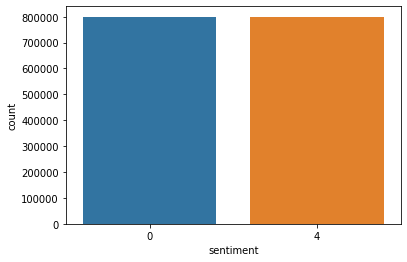

In [12]:
# Contagem da classe
sns.countplot(data=train_data, x='sentiment');

Vemos portando que a base não está desbalanceada. Criaremos agora a base de testes.



In [13]:
# Criação da base de testes
test_data = pd.read_csv('/content/trainingandtestdata/test.csv', 
                        encoding='latin1',
                        names=cols,
                        header=None,
                        engine='python')

In [14]:
# Visualizando os primeiros registros
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [15]:
# Visualizando o shape
test_data.shape

(498, 6)

In [16]:
# Valores únicos dos sentimentos da base de testes
test_data['sentiment'].unique()

array([4, 0, 2])

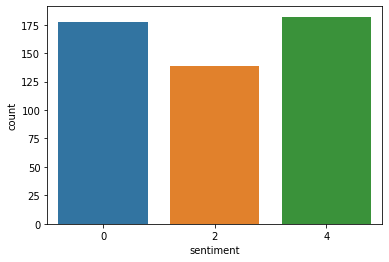

In [17]:
# Contagem da classe
sns.countplot(data=test_data, x='sentiment');

Notamos que a base de testes tem uma estrutura diferente dos "sentimentos" em relação à base de treinos, apresentando um sentimento "neutro". Por isso não iremos utilizá-la e faremos toda a nossa análise na própria base de treinos.

### 3.2) Separando a base de dados

Antes de fazer a limpeza iremos criar um outro dataframe excluindo as colunas desnecessárias e a seguir separaremos uma amostra com 15% da base original para fazer o treinamento do modelo.

In [18]:
# Criando novo dataframe
data = train_data

# Deletando colunas desnecessárias
data.drop(axis=1, columns=['id', 'date', 'query', 'user'], inplace=True)

# Visualizando o novo dataframe
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


- Criando feature e classe

In [19]:
# Feature dos textos
X = data.iloc[:, 1].values

# Classe
y = data.iloc[:, 0].values

In [20]:
# Visualizando o array X
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [21]:
# Visualizando o array y
y

array([0, 0, 0, ..., 4, 4, 4])

Como a base de dados é muito grande (1600000 registros) iremos separar uma amostra (15%) desta base para fazermos o treinamento. Assim, segue o código abaixo.

In [22]:
# Importando a biblioteca
from sklearn.model_selection import train_test_split

# Pegando uma amostra da base original
X, _, y, _ = train_test_split(X, y, test_size=0.85, stratify=y)

In [23]:
# Visualizando o shape
X.shape, y.shape

((240000,), (240000,))

In [24]:
# Valores únicos e suas quantidades
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

### 3.3) Limpeza dos textos

Nesta subção iremos limpar de fato os textos e para isso criaremos uma função que fará o trabalho. Para teste, usaremos um texto aleatório da base de dados.

In [25]:
# Criando a função
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r'@[A-Za-z0-9_]+', ' ', tweet)
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet)
  tweet = re.sub(r'[^A-Za-z.!?]', ' ', tweet)
  tweet = re.sub(r' +', ' ', tweet).strip()
  return tweet

In [26]:
# Criando um texto qualquer para teste
text = data['text'][0]
text

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [27]:
# Testando a função
text = clean_tweets(text)
text

'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

- Remoção de stop words

Iremos aqui escrever uma função para remoção de stop words dos tweets.

In [28]:
# Criando um objeto para lingua inglesa
nlp = sp.load('en')
nlp

In [29]:
# Criando lista de stop words
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)

{'if', 'quite', 'through', 'afterwards', 'may', 'namely', 'indeed', 'became', 'before', 'front', 'which', 'call', '‘re', 'something', 'he', 'ten', 'whole', '‘m', 'although', 'former', 'there', 'please', 'further', '’m', 'eleven', 'cannot', 'due', 'empty', 'several', 'doing', 'below', 'via', 'hereafter', 'should', 'none', 'among', 'well', 'keep', 'therefore', 'of', 'amount', 'are', 'thus', 'whatever', 'yourself', 'this', 'anyone', 'next', 'thereby', 'whereas', "'d", 'hers', 'because', 'formerly', 'top', 'some', '‘d', 're', 'just', 'have', 'when', 'twenty', 'herself', '‘s', 'then', 'behind', 'ourselves', 'its', 'otherwise', 'almost', 'one', 'four', 'neither', 'per', 'the', 'alone', 'another', 'others', 'beforehand', 'regarding', 'five', 'seeming', 'beside', 'throughout', 'already', 'still', 'a', 'might', 'being', 'here', 'nevertheless', 'me', 'either', 'eight', 'last', 'nor', 'six', 'twelve', 'various', 'about', 'each', 'however', 'must', 'somehow', 'using', 'did', 'or', 'were', 'does', 

In [30]:
# Contando total de stop words
len(stop_words)

326

In [31]:
# Função para remover stop words
def remove_stop_words(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = [token.text for token in document]
  words = [word for word in words if word not in stop_words \
           and word not in string.punctuation]
  words = ' '.join(words)

  return words

In [32]:
remove_stop_words(text)

'awww s bummer shoulda got david carr day d'

Para realmente fazermos a limpeza dos textos iremos juntar as duas funções anteriores em apenas uma para otimizar este trabalho.

In [33]:
# Criando a função final
def clean_tweets2(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r'@[A-Za-z0-9_]+', ' ', tweet)
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet)
  tweet = re.sub(r'[^A-Za-z.!?]', ' ', tweet)
  tweet = re.sub(r' +', ' ', tweet).strip()

  tweet = tweet.lower()
  document = nlp(tweet)

  words = [token.text for token in document]
  words = [word for word in words if word not in stop_words \
           and word not in string.punctuation]
  words = ' '.join(words)
  return words

- Limpeza de todos os reviews

Iremos testar a função acima.

In [34]:
# Definindo a variável contendo um review
text2 = data['text'][0]
text2

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [35]:
# Aplicando a função acima
text2 = clean_tweets2(text2)
text2

'awww s bummer shoulda got david carr day d'

Agora sim aplicaremos a função nos reviews.

In [36]:
# Criando variável com reviews limpos
data_clean = [clean_tweets2(tweet) for tweet in X]

In [37]:
# Retornando alguns registros aleatoriamente
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

definitely having nvidia problem macbook pro appt genius bar
called eat lunch didn t answer
hip hurts guess s time naproxen
welcome
wassup u morning
ehh plan assignments tonight drain fingr hurts like got cut t ..
bot type accounts win stuff
got fucking retainer .... ugh m gning bed ..
actionscript xml gurus want project plate time finish ll pay
s raining internet connection f


Uma outra alteração que devemos fazer é na variável y, uma vez que ela apresenta valores 0 e 4 para comentários negativos e positivos respectivamente. Então substituiremos por 0 e 1.

In [38]:
# Definindo a variável
data_labels = y
np.unique(data_labels)

array([0, 4])

In [39]:
# Alterando de 4 para 1
data_labels[data_labels == 4] = 1

In [40]:
# Confirmando a alteração
np.unique(data_labels)

array([0, 1])

### 3.4) Tokenização

O processo de tokenização consiste em converter todos os textos em números. Este processo é extremamente necessário uma vez que iremos trabalhar com algorítmos que não aceitam dados no formato "string".

In [41]:
# Criando objeto para tokenização
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean,
                                                                      target_vocab_size=2**16)

In [42]:
# Verificando tamanho do vocabulário
tokenizer.vocab_size

51999

Note que iremos utilizar um vocabulário contendo 51912 palavras. 

A seguir iremos de fato tokenizar o vocabulário e para isso faremos um teste para verificar como funciona o processo.

In [43]:
# Criando id's de teste para texto qualquer
ids = tokenizer.encode('i am happy')
ids

[254, 3533, 367]

In [44]:
# Decodificando os id's
text = tokenizer.decode(ids)
text

'i am happy'

Assim, notamos que nosso tokenizador está funcionando corretamente. Aplicaremos agora este mesmo processo para os comentários da nossa base.

In [45]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [46]:
# Retornando alguns registros aleatoriamente após tokenização
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[26, 3699, 957, 593, 705, 607, 708, 593, 547, 4, 614, 51855]
[32, 19, 1135, 1303, 704, 154, 266, 80, 2226]
[642, 935]
[8106, 30709, 30514, 21, 13, 3, 2, 8554, 1, 154, 2055, 31, 756, 475, 7, 1507]
[47832, 27, 97, 3, 1939, 51843]
[11, 1071, 31009, 6, 1106, 6, 1, 3299, 2655]
[56, 1945, 252, 738, 2216, 2114, 960, 852, 201, 1285]
[1, 607, 13, 3, 7, 2326, 112, 23, 1727]
[194, 2, 1304]
[296, 4318, 1748, 151, 21, 4174, 2749, 181, 2038, 5692, 941]


### 3.5) Padding (preenchimento)

Na última subseção fizemos a tokenização dos tweets e obtemos cada um deles na forma de id's, com cada palavra tendo seu id único. Mas note do último resultado que, dependendo do tamanho, o tweet pode ter números diferentes de id's. Desta forma, teremos que deixar todos as listas representando os tokens com o mesmo tamanho e para isso faremos um processo conhecido como ***padding*** (ou simplesmente preenchimento) que consiste igualar os seus tamanhos apenas acrescentando zeros.

Assim, esta subseção será reservada para este fim.

In [47]:
# Pegando a sentença com mais caracteres
max_len = max([len(sentence) for sentence in data_inputs])
max_len

64

In [48]:
# Fazendo o preenchimento
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding='post',
                                                            maxlen=max_len)

In [49]:
# Retornando alguns registros aleatoriamente após padding
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  775    13     3   605   318   363   308 12753  4548     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[ 106 2965  234  263   79  845   22 9058 5520 4902  335    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[   26 16351 34777  8022     4  1582     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0    

### 3.5) Divisão da base de dados entre treinamento e teste

Agora iremos utilizar a base finalizada acima para dividi-la em bases de treinamento e teste.

In [50]:
# Fazendo a divisão da base
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=.3,
                                                                        stratify=data_labels)

In [51]:
# Visualizando um resultado
train_inputs[0]

array([  16,  364,    6,   25,  338, 2239,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [52]:
# Visualizando o shape dos dados de treino
train_inputs.shape, train_labels.shape

((168000, 64), (168000,))

In [53]:
# Visualizando o shape dos dados de teste
test_inputs.shape, test_labels.shape

((72000, 64), (72000,))

## 4) Construção do modelo

Nesta etapa iremos de fato fazer a construção do modelo que irá receber os tweets tratados anteriormente.